<a href="https://colab.research.google.com/github/ScipioAfricanus76/Painting-Identification/blob/main/Painter_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from bs4 import BeautifulSoup as BS
import os
from os import listdir
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
from PIL import Image

class image_downloader: # We had the idea to create a class for easier downloading from multiple websites. Streamlines several processes
    painter_list = []
    def __init__(self, painter, url = r'https://www.yourmom.com', directory_path = f'/content/artist_data/'): # Changed to colab directory!!!!!!!!!!!!!
        self.painter = painter # We found the joke url humurous, and it allowed for the calling of artists whose websites can't be downloaded using classes
        self.url = url
        self.directory_path = directory_path
        self.painter_list += [painter]
    def prepend(self, list, str): # Used in below image_getter function to create working links

        # Using format()
        str += '{0}'
        list = [str.format(i) for i in list]
        return(list)

# Found prepend function from https://www.geeksforgeeks.org/python-insert-the-string-at-the-beginning-of-all-items-in-a-list/


    def image_getter(self, url): # Returns list of all image links on page, used in later image downloader
        painter_images = []
        painter_image_links = [] # create empty lists to store image links

        r = requests.get(url) # opens url
        soup = BS(r.text, 'html.parser') # parses through html text in specified url

        for image_source in soup.find_all('img'):
            painter_images.append(image_source['src']) # Adds source listed in html img class
            # Does not include website name, just extension for website. Have to change each string to get usable source.

        # Here we find what kind of site the photos are on to properly add full source to link list

        if '.com' in url:
            url_splitter = '.com'
        elif '.org' in self.url:
            url_splitter = '.org'
        elif '.gov' in self.url:
            url_splitter = '.gov'
        else:
            url_splitter = '.' # use dot as default splitter in case of unusual site type.

        url_opening = f'{self.url.split(url_splitter)[0]}{url_splitter}' # Creates opener which is necessary addition to links

        painter_image_links = self.prepend(painter_images, url_opening) # Adds website opener to extensions found earlier
        return painter_image_links

    def image_downloader(self, num_images = 113): # To print all pages multiply number of pages by 113.
        num_pages = num_images//113 # 96 paintings on sites used, with 17 additional images for website use. Assumes set to 96 paintings in view.
        # First 8 and last 9 images for each page are not what we are looking for, so we'll trim them after downloading

        num_images_downloaded = 0

        for j in range(num_pages):
            url = f'{self.url}&pageno={j+1}' # common formatting of art websites, iterates through pages.

            for i in range(len(self.image_getter(url))):
                # Download section from # https://www.scrapingbee.com/blog/download-image-python/ inspiration for code

                image_source = self.image_getter(url)[i] # Sets source for image, using links generated in image_getter
                file_name = f'{self.painter}{(i + 13) + (j ) * 100}.png' # Creates file name to be downloaded under. Created file name iteration system from scratch.

                download = requests.get(image_source, stream = True) # Sets download for url to current working path. Usually user folder if in jupyter notebook

                if download.status_code == 200: # Determines if url grab and path for download was successful
                    with open(file_name,'wb') as f: # creates a file with specified file name. wb writes binary for images.
                        shutil.copyfileobj(download.raw, f) # res.raw keeps file decompressed (already small), and f is file name
                        num_images_downloaded += 1
                else:
                    print('Image couldn\'t be retrieved')

        print(f'{num_images_downloaded} images have been downloaded.')

    def painting_count(self): # Counts number of paintings downloaded. Do after cleaning to get true final count.
        # Change this to be length of row of dataframe from data_retrieve.
        num_usable_paintings = self.data_retrieve().shape[0]
        #dir_path = self.directory_path + f'{self.painter}_Images' # to work, put your own directory information. This is mine

        #for row in self.data_retrieve().shape[0]:
        #num_usable_paintings += 1
        return num_usable_paintings

    def data_retrieve(self):
        data = []
        img_size = int(128) # 224 seems to be a common image size used with Keras, and we know it works and fits our data. So 224x224
        dir_path = f'{self.directory_path}RGBA_{self.painter}' # changed to RGBA after RGBA folder created
        for image in os.listdir(dir_path):
            try:
                image_array = cv2.imread(os.path.join(dir_path, image))
                image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2RGBA) # changes RGB to RGBA, gets more data to look at w/ opacity
                resized_array = cv2.resize(image_array, (img_size, img_size))
                data.append([resized_array, self.painter])
            except Exception as why:
                pass

        data = np.array(data, dtype=object)
        useful_df = pd.DataFrame(data, columns = ['pixel_RGB_values','painter'])
        useful_df = useful_df [1:] # we don't have an image zero, so we can simply ignore it. Gives None for RGBA values otherwise
        return useful_df

    def train_data(self): # Change self.painting_count to be the number of rows of each data retrieve dataframe.
        train_num = round(self.painting_count() * .85) # round to ensure whole numbers. Can't have part of an image
        painter_df = self.data_retrieve()
        train_data = [painter_df[:train_num]]
        return train_data

    def test_data(self):
        test_num = round(self.painting_count() * .15) # 15% of data is left for testing, while 85% is used for training.
        painter_df = self.data_retrieve()
        test_data = [painter_df[-test_num:]]
        return test_data

    def convert_to_png(self): # saves new RGBA versions of files
        print(f'{self.directory_path}{self.painter}_Images')
        for image in os.listdir(f'{self.directory_path}{self.painter}_Images'):
          try:
            path = f'{self.directory_path}{self.painter}_Images/{image}'
            im = Image.open(path)
            im.convert('RGBA').save(f'{self.directory_path}RGBA_{self.painter}/{image}') # not working
          except Exception as why:
            print(why)


In [ ]:
# Picasso Website had different format than the others, so we had to do a manual download instead of using the class
r = requests.get('https://www.pablopicasso.org/picasso-paintings.jsp')

soup = BS(r.text, 'html.parser')  # Switched to r.content as a change

image = soup.find_all('div')  # Important change here to 'div'.

picasso_images = []
picasso_image_links = [] # Added this due to formatting of website

for a in soup.find_all('img'):
    picasso_images.append(a['src'])  # These are sources within the pablo picasso website. Start needs to be http://pablopicasso.org

url_opening = 'http://pablopicasso.org'
picasso_image_links = Picasso.prepend(picasso_images, url_opening) # makes files full links to go to!

# https://www.scrapingbee.com/blog/download-image-python/ inspiration for code
import shutil
for i in range(len(picasso_image_links)): # set up for loop for saving, self addition to code
    url = picasso_image_links[i] # Changed this due to formatting of list made
    file_name = f'PicassoImage{i+1}.png' # iterate through file names, changed from code.
    res = requests.get(url, stream = True) # Gets url

    if res.status_code == 200: # Determines if url grab was successful, its the code returned if successful
        with open(file_name,'wb') as f: # creates a file with specified file name. wb writes binary for images.
            shutil.copyfileobj(res.raw, f) # res.raw keeps file decompressed (already small), and f is file name
    else:
        print('Image couldn\'t be retrieved')


In [ ]:
Monet = image_downloader('Monet', 'https://www.claudemonetgallery.org/the-complete-works.html?ps=96')
VanGogh = image_downloader('VanGogh', 'https://www.vincent-van-gogh-gallery.org/the-complete-works.html?ps=96')
Picasso = image_downloader('Picasso')

In [ ]:
Monet.image_downloader()
Picasso.image_downloader() # downloads default 113 images, can increase but not beyond total images

In [ ]:
# Here we convert images to RGBA
Monet.convert_to_png()
VanGogh.convert_to_png()
Picasso.convert_to_png()


/content/artist_data/Picasso_Images


In [ ]:
#Here we start reading the csv, nice to have to show data in case of future expansion.
painters = pd.read_csv(r'/content/artist_data/painters_MAD2502_Final.csv') # raw string to avoid multiple \

# Now we need to create a data frame with weights for the training. The less paintings, the higher weight we want to give to each painter.
# Picasso, for example, should have a much higher weight than Van Gogh.
# In general, class weight is calculated as weight = num_samples / (num_classes * num_samples_class)
painters = painters[['Painter', 'Num_Paintings']]
painters['weight'] = painters.Num_Paintings.sum() / (painters.shape[0] * painters.Num_Paintings)
painters


FileNotFoundError: ignored

In [ ]:
# As we can see, Van Gogh and Monet have fairly reasonable weights, while Picasso weights are wildly imbalanced
# We will create another dataframe using just Van Gogh and Monet to train and compare results.
painters_new = painters[0:2]
painters_new['weight'] = painters_new.Num_Paintings.sum() / (painters_new.shape[0] * painters_new.Num_Paintings)
painters_new #Error occurs due to calculation of new weights. No issues with data frame itself.

<ipython-input-4-86d5307a0009>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  painters_new['weight'] = painters_new.Num_Paintings.sum() / (painters_new.shape[0] * painters_new.Num_Paintings)


,Painter,Num_Paintings,weight
0,Vincent Van Gogh,2190,0.917123
1,Claude Monet,1827,1.099343


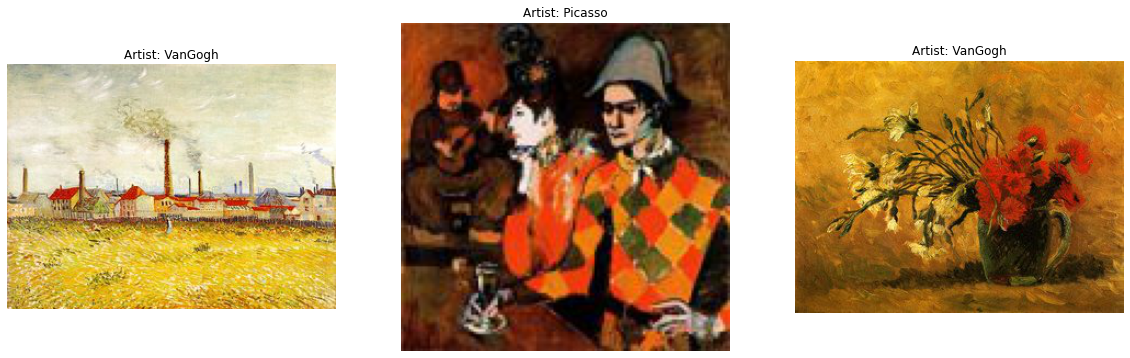

In [ ]:
# Some basic image exploration Below
#https://www.kaggle.com/code/supratimhaldar/deepartist-identify-artist-from-art/notebook
# above is source of this section of code
painters_name = ['VanGogh', 'Monet', 'Picasso'] # Change to code.

num_images = 3

fig, axes = plt.subplots(1, num_images, figsize=(20,10))

# See if all directories exist

for i in range(num_images): # Below changed directory information
    random_artist = random.choice(painters_name)
    images_dir = r'/content/artist_data/'

    random_image = random.choice(os.listdir(os.path.join(images_dir, f'{random_artist}_Images')))
    random_image_file = os.path.join(images_dir, f'{random_artist}_Images', random_image)
    image = plt.imread(random_image_file,0) # 0 addition removed header issue.
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
# This installs tensorflow, a machine learning tool, and keras from that.
#Also installs a few other tools which will be useful later.

In [ ]:
VanGogh1 = VanGogh.data_retrieve()
Picasso1 = Picasso.data_retrieve()
Monet1 = Monet.data_retrieve()
all_painter_df = [Monet1,VanGogh1,Picasso1]
painters_final_df = pd.concat(all_painter_df)
print(painters_final_df[0:10])

                                     pixel_RGB_values painter
1   [[[171, 191, 180, 255], [165, 202, 185, 255], ...   Monet
2   [[[103, 150, 174, 255], [140, 181, 203, 255], ...   Monet
3   [[[113, 173, 172, 255], [155, 196, 198, 255], ...   Monet
4   [[[116, 133, 146, 255], [152, 168, 184, 255], ...   Monet
5   [[[178, 183, 186, 255], [192, 195, 199, 255], ...   Monet
6   [[[161, 173, 172, 255], [181, 194, 194, 255], ...   Monet
7   [[[107, 145, 165, 255], [134, 170, 190, 255], ...   Monet
8   [[[68, 129, 123, 255], [54, 115, 109, 255], [6...   Monet
9   [[[202, 223, 223, 255], [198, 226, 226, 255], ...   Monet
10  [[[230, 230, 230, 255], [245, 245, 245, 255], ...   Monet


In [ ]:
painter_list = painters_final_df['painter'].value_counts() # Change this to have new weights
painter_list # Save this for 'new' model and compare it to the old one.
painter_list1 = pd.DataFrame(painter_list)

painter_list1.columns = ['Paintings']
painter_list1['weights'] = painter_list1.Paintings.sum() / (painter_list1.shape[0] * painter_list1.Paintings)
painter_list1

,Paintings,weights
Monet,1402,0.620067
VanGogh,1032,0.842377
Picasso,174,4.996169


In [ ]:
batch_size = 64 # Maybe change to 128, decreased batch size since high batches seemed to provide low model accuracy
train_input_shape = (256, 256, 3) # 128 x 128 pixels, with three potential painters., changing to 256 x 256 to see if higher accuracy can be achieved with more pixel data
num_classes = len(image_downloader.painter_list) # gets number of painters
all_data = ImageDataGenerator(validation_split = 0.2, rescale = 1./255) # Changed here to .2 so training would be slightly faster
painter_files = ['RGBA_Monet','RGBA_Picasso','RGBA_VanGogh']

training_generation = all_data.flow_from_directory(
    directory = r'/content/artist_data', # Not all photos are there could be issue?
    class_mode = 'categorical',
    target_size = train_input_shape[0:2],
    batch_size = batch_size,
    subset = 'training',
    #shuffle = True, Taking out shuffle
    classes = painter_files
    )

test_generation = all_data.flow_from_directory( # Worked after uploading everything to google colab files.
    directory = r'/content/artist_data',
    class_mode = 'categorical',
    target_size = train_input_shape[0:2],
    batch_size = batch_size,
    subset = 'validation',
    # shuffle = True, Taking out shuffle for slightly faster performance
    classes = painter_files
)

training_step_size = training_generation .n// training_generation.batch_size
test_step_size = test_generation .n// test_generation.batch_size
print(training_step_size, test_step_size) # WOrk on this, use kaggle link as source.

Found 2090 images belonging to 3 classes.
Found 521 images belonging to 3 classes.
32 8


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True # INitially true, changed to False to see if error could be solved

In [ ]:
# This and above is using https://www.kaggle.com/code/supratimhaldar/deepartist-identify-artist-from-art/notebook

X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(num_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
n_epoch = 3 # Changed to 3 from 10, each iteration takes about 10 minutes. so 3 is bare minimum for testing.

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1,
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,
                              verbose=1, mode='auto')
class_weights = painter_list1['weights'].to_dict() # Potential issue here. Data not represented with painter['weight']
class_weight1 = painters['weight'].to_dict()
print(class_weight1)

{0: 0.9171232876712329, 1: 1.0993431855500821, 2: 7.6105072463768115}


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Train the model - all layers
history1 = model.fit_generator(generator=training_generation, steps_per_epoch=training_step_size, # It redownloaded Monet Images as VanGoghs as well. Painful.
                    validation_data=test_generation, validation_steps=test_step_size,
                    epochs=n_epoch,
                    shuffle=True,
                    verbose=1,
                    callbacks=[reduce_lr],
                    use_multiprocessing=True,
                    workers=16,
                    class_weight=class_weights
                    )

In [ ]:
history1 = model.fit(training_generation, steps_per_epoch=training_step_size, # Had Monet and VanGogh as same images. That sucks.
                    validation_data=test_generation, validation_steps=test_step_size,
                    epochs=n_epoch,
                    shuffle=True,
                    verbose=1,
                    callbacks=[reduce_lr],
                    use_multiprocessing=True,
                    workers=16,
                    class_weight=class_weight1
                    )

In [ ]:
# Freeze core ResNet layers and train again
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

n_epoch = 20
history2 = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=test_generation, validation_steps=test_step_size,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weight1
                             )


In [ ]:
# Here we look at model history
# Below from kaggle : https://www.kaggle.com/code/supratimhaldar/deepartist-identify-artist-from-art/notebook
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['acc'] = history1.history['acc'] + history2.history['acc']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
history['val_acc'] = history1.history['val_acc'] + history2.history['val_acc']
history['lr'] = history1.history['lr'] + history2.history['lr']
# Plot the training graph
def plot_training(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))

    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')

    plt.show()

plot_training(history)

In [ ]:
# Below from kaggle

# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = painter_files.tolist()

def showClassficationReport_Generator(model, test_generation, test_step_size):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(test_step_size):
        (X,y) = next(test_generation)
        y_pred.append(model.predict(X))
        y_true.append(y)

    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]

    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()

    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()

    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False,
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()

    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(num_classes), target_names=painter_files.tolist()))

showClassficationReport_Generator(model, test_generation, test_step_size)

In [ ]:
# More kaggle things for data exploration


# Prediction
from keras.preprocessing import *

n = 5
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    random_artist = random.choice(painter_files)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)

    # Original image

    test_image = image.load_img(random_image_file, target_size=(train_input_shape[0:2]))

    # Predict artist
    test_image = image.img_to_array(test_image)
    test_image /= 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = training_generation.class_indices
    labels = dict((v,k) for k,v in labels.items())

    #print("Actual artist =", random_artist.replace('_', ' '))
    #print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
    #print("Prediction probability =", prediction_probability*100, "%")

    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
                .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                        prediction_probability*100)

    # Print image
    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()